In [8]:
import numpy as np
import sys
from numba import njit, prange
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed
import math
from skimage import measure
from src import functions as fcts

print(sys.executable)

/Users/isabellegarnreiter/opt/anaconda3/envs/vesicleSTORM/bin/python


In [3]:
def filter_clusters(img, min_area, max_area):
    """Filters clusters in 3D image based on their area"""
    regions = measure.regionprops(img)
    filtered_img = np.zeros_like(img)
    for region in regions:
        if region.area >= min_area and region.area<=max_area:
            for coord in region.coords:
                filtered_img[coord[0], coord[1], coord[2]] = region.label

    return filtered_img


In [4]:
#initialise paramaters for the detection/selection of synapses

params = {}
params['true_roi_size'] = (49660,49660,1100)
params['sf']  = (68, 68, 180)
params['kernel_size'] = (40,40,2)
params['sigma'] = 8
params['min_threshold_ves'] = 4
params['min_peak_dist'] = 16
params['min_cluster_area'] = 32
params['max_cluster_area'] = 32000


In [5]:
#choose file for rotation report

file_loc = '/users/isabellegarnreiter/documents/vesicleSTORM/data/STORM_csv_files/34/'

vesicle_file = '210414 SPON647_PSD680 8DIV_CellZone2_w2'
psd_file = '210414 SPON647_PSD680 8DIV_CellZone2_w1'

ex_data_vesicles = pd.read_csv(file_loc+vesicle_file)[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)
ex_data_vesicles[:,2] +=550

ex_data_PSD = pd.read_csv(file_loc+psd_file)[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)
ex_data_PSD[:,2] +=550


In [9]:
true_roi_size = params['true_roi_size'] 
sf = params['sf']
kernel_size = params['kernel_size']
sigma = params['sigma']
min_threshold_ves = params['min_threshold_ves']
min_peak_dist = params['min_peak_dist'] 
min_cluster_area = params['min_cluster_area']
max_cluster_area = params['max_cluster_area']

image_size = (true_roi_size[0]//sf[0], true_roi_size[1]//sf[1], true_roi_size[2]//sf[2])

#plot the locations of the vesicles using the same image size as above to a single pixel size and using a large point spread function
image = fcts.map_to_im(ex_data_vesicles, true_roi_size, image_size)
indices = np.array(np.where(image>100))
image[indices.T] = 0
gaussian_fit_image = fcts.get_gaussiankde(image, kernel_size, sigma)

#calculate the intensity threshold for the large PSF images, depending on an arbitrary intensity threshold, dependent on the mean and std of each image.
threshold = gaussian_fit_image.mean() + gaussian_fit_image.std() * min_threshold_ves

#create a mask of the large PSF images where for the pixels above the threshold
mask = (gaussian_fit_image > threshold) * 1

#get the local peaks, defining the central coordinate of synapses
peak_coords = peak_local_max(gaussian_fit_image,labels = mask)

#filter the peak distances to exclude peaks which are too close to one another and replace them by the  midway point
peak_coords = np.array(fcts.filter_peaks(peak_coords, min_peak_dist))

#create labels for each peak
shell = np.zeros(image.shape, dtype=bool)
shell[tuple(peak_coords.T)] = True
markers, _ = ndi.label(shell)

#apply watershed to seperate clusters, based on the previously computed mask and the local peaks
synapse_clusters = watershed(-gaussian_fit_image, markers = markers, mask=mask, watershed_line=True)


#filtered_clusters
filtered_clusters = filter_clusters(synapse_clusters, min_cluster_area, max_cluster_area)


points= fcts.get_points(ex_data_vesicles, filtered_clusters, params)
points = np.concatenate(list(points.values()), axis=0)
points.shape

(35714, 3)

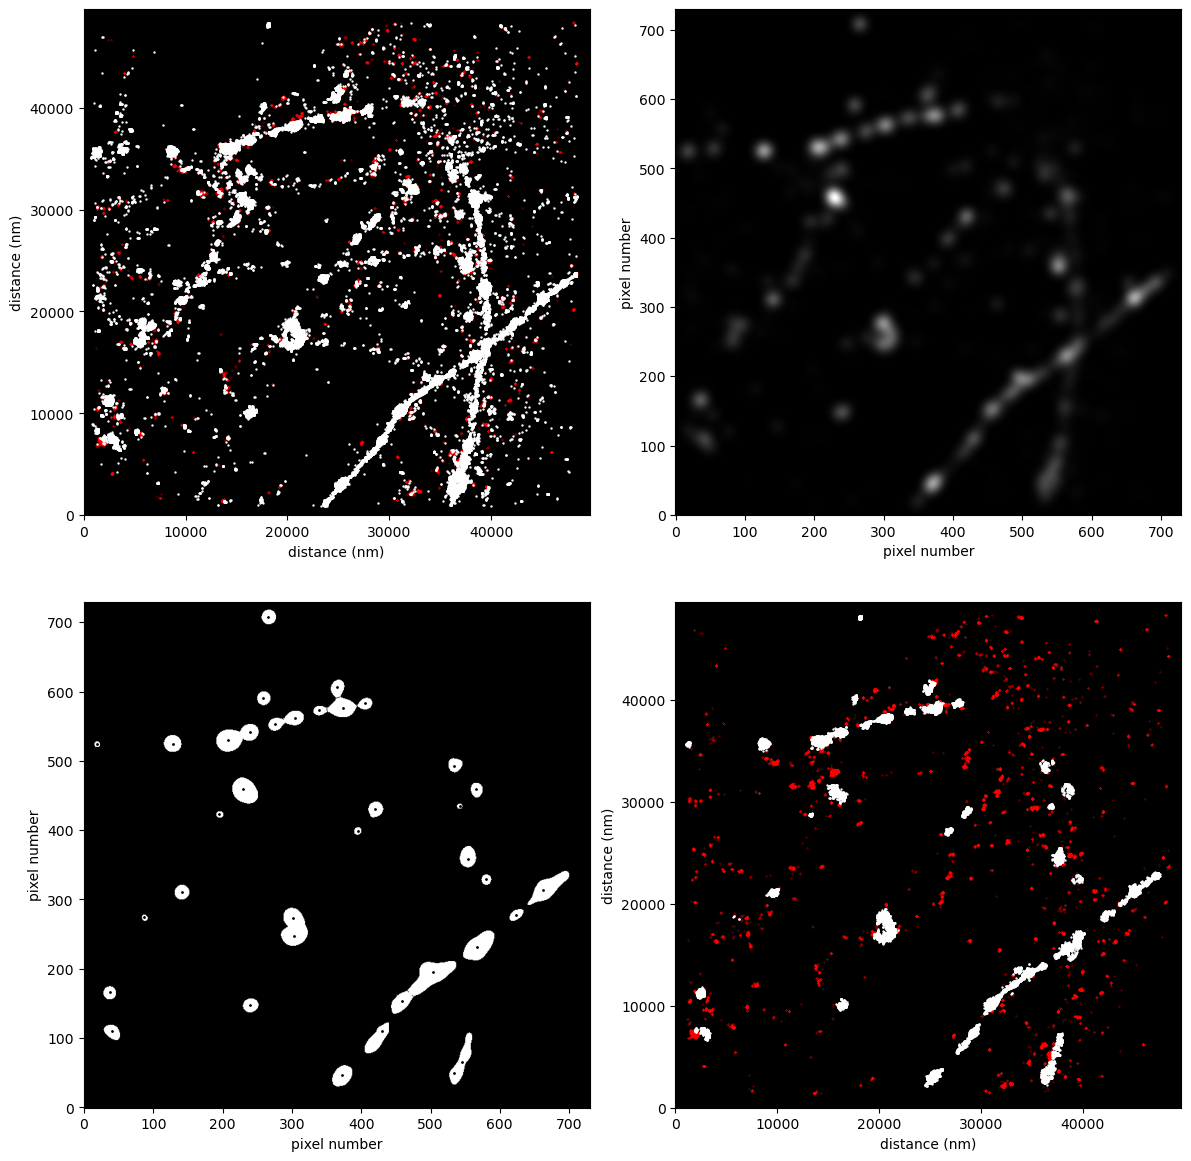

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0,0].scatter(ex_data_PSD[:,1], ex_data_PSD[:,0], s=0.05, color='red')
axes[0,0].scatter(ex_data_vesicles[:,1], ex_data_vesicles[:,0], s=0.5, color='white')
axes[0,0].set_facecolor('black')
axes[0,0].set_aspect('equal')
axes[0,0].set_xlim(0, 49660)
axes[0,0].set_ylim(0, 49660)
axes[0,0].set_xlabel('distance (nm)')
axes[0,0].set_ylabel('distance (nm)')

gaussian_fit_image_2d = np.sum(gaussian_fit_image, axis=2)
axes[0,1].imshow(gaussian_fit_image_2d, origin = 'lower',cmap = 'gray')
axes[0,1].set_xlabel('pixel number')
axes[0,1].set_ylabel('pixel number')

filtered_clusters_2d = np.sum(filtered_clusters, axis=2)
filtered_clusters_2d = (filtered_clusters_2d > 0)*1
axes[1,0].imshow(filtered_clusters_2d, origin = 'lower', cmap = 'gray')
axes[1,0].scatter(peak_coords[:,1], peak_coords[:,0], s=1, color='black')
axes[1,0].set_xlabel('pixel number')
axes[1,0].set_ylabel('pixel number')

axes[1,1].scatter(ex_data_PSD[:,1], ex_data_PSD[:,0], s=0.05, color='red')
axes[1,1].scatter(points[:,1], points[:,0], s=0.5, color='white')
axes[1,1].set_facecolor('black')
axes[1,1].set_aspect('equal')
axes[1,1].set_xlim(0, 49660)
axes[1,1].set_ylim(0, 49660)
axes[1,1].set_xlabel('distance (nm)')
axes[1,1].set_ylabel('distance (nm)')


plt.tight_layout()